In [8]:
import pyswarms as ps
import kornia
import functools


class ShadowAttack:
    def __init__(self, traversibility_model: nn.Module, loss_fn: nn.Module, PSO_params: Dict):
        """_summary_

        Args:
            traversibility_model (nn.Module): Model.
            loss_fn (nn.Module): Computes loss between prediction yhat and true y.
        """
        self.model = traversibility_model
        self.loss_fn = loss_fn
        self.PSO_params = PSO_params

    def _compute_particle_loss(self, particle: torch.Tensor, X: torch.Tensor, y: torch.Tensor):
        # Apply the shadow mask represented by the particle on the sequence of RGB imgs.
        img_h, img_w = X.shape[-2:]
        shadow_mask = self.get_shadow_mask(particle, img_h, img_w)
        X_p = self.apply_shadow_mask(shadow_mask, X)
        # Compute the outputz
        y_p = self.model(X_p)
        # Compute loss between unperturbed output and perturbed output
        loss = self.loss_fn(y, y_p)
        return loss

    def get_shadow_mask(self, shadow_polygon: torch.Tensor, img_h: int, img_w: int):
        """Get binary shadow mask corresponding to the shadow polygon to Mask in the given image sizes"""
        img_mask = torch.zeros((img_h, img_w), dtype=torch.uint8)

        # Generate Cartesian product of pixel coordinates
        rows = torch.arange(img_h)
        cols = torch.arange(img_w)
        img_mask_points = torch.cartesian_prod(rows, cols)  # Shape: (img_h * img_w, 2)

        # Get points inside triangle
        points_inside = self._check_points_inside_triangle(shadow_polygon, img_mask_points)

        # Assign "true" to points inside the triangle
        img_mask[img_mask_points[points_inside, 0], img_mask_points[points_inside, 1]] = 1

        return img_mask

    def apply_shadow_mask(self, shadow_mask: torch.Tensor, X: torch.Tensor, shadow_coefficient: float = 0.43):
        """Apply shadow mask on top of model's input X."""
        # Convert the RGB images to LAB color space
        X_lab = X.detach().clone().double()
        X_lab[:, :3] /= 255.0
        X_lab[:, :3] = kornia.color.rgb_to_lab(X_lab[:, :3])
        # Modify L value based on shadow_mask and shadow_coefficient
        X_lab[:, 0][shadow_mask.expand(size=(len(X_lab), -1, -1)) == True] *= shadow_coefficient
        # Clip L value
        X_lab[:, 0] = torch.clip(X_lab[:, 0], min=0.0, max=100.0)
        # Convert back to RGB color space
        X_lab[:, :3] = kornia.color.lab_to_rgb(image=X_lab[:, :3], clip=True)
        X_lab[:, :3] *= 255.0
        return X_lab

    def _check_points_inside_triangle(self, vertices, points):
        """Check whether batch of points are inside the defined triangle."""
        # Add the third dimension
        n = len(points)
        vertices_3d = torch.cat([vertices, torch.zeros(len(vertices), 1)], dim=1)
        points_3d = torch.cat([points, torch.zeros(n, 1)], dim=1)
        # Check by cross products
        a, b, c = vertices_3d
        cross1 = torch.cross(torch.broadcast_to(b - a, (n, 3)), points_3d - a, dim=1)[:, 2] <= 0
        cross2 = torch.cross(torch.broadcast_to(c - b, (n, 3)), points_3d - b, dim=1)[:, 2] <= 0
        cross3 = torch.cross(torch.broadcast_to(a - c, (n, 3)), points_3d - c, dim=1)[:, 2] <= 0
        return ~(cross1 ^ cross2) & ~(cross2 ^ cross3)

    def attack(self, X):
        """
        X (Tensor of shape (sequence_size, 3+1, Hi, Wi)): Sequence of RGB (first three channels) and Depth (last channel) images.
        """

        # Compute model's unperturbed output y and store it as reference.
        # y is traversability images (2, H, W). Values bounded [0,1]
        n, c, h, w = X
        y = self.model(X)

        # Check this to implement your PSO
        # https://github.com/hncszyq/ShadowAttack/blob/master/pso.py

        # Use Particle Swarm Optimization to search for perturbed images X_p that minimizes loss
        swarm_size = 100
        particle_dim = 6
        options = {"c1": 1.5, "c2": 1.5, "w": 0.5}
        num_iters = 1000
        constraints = (
            np.zeros(particle_dim),
            np.ones(particle_dim) * 255.0,
        )

        optimizer = ps.single.GlobalBestPSO(n_particles=swarm_size, dimensions=particle_dim, options=options)

        # Create swarm loss function
        compute_particle_loss_fn = functools.partial(self._compute_particle_loss, X=X, y=y)
        compute_swarm_loss_fn = torch.vmap(compute_particle_loss_fn)
        cost, joint_vars = optimizer.optimize(compute_swarm_loss_fn, iters=num_iters)

## Quick Testing


Applying shadow mask


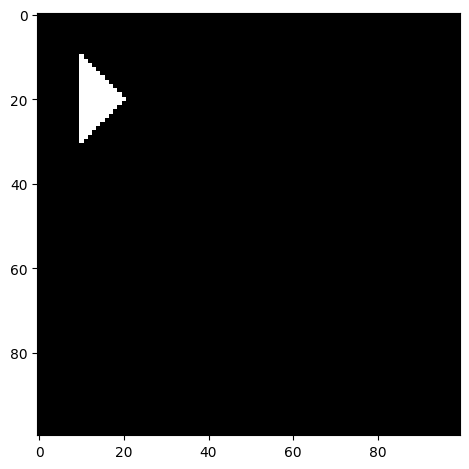

[[[59 60 60]
  [59 60 60]
  [59 60 60]
  ...
  [59 60 60]
  [59 60 60]
  [59 60 60]]

 [[59 60 60]
  [59 60 60]
  [59 60 60]
  ...
  [59 60 60]
  [59 60 60]
  [59 60 60]]

 [[59 60 60]
  [59 60 60]
  [59 60 60]
  ...
  [59 60 60]
  [59 60 60]
  [59 60 60]]

 ...

 [[59 60 60]
  [59 60 60]
  [59 60 60]
  ...
  [59 60 60]
  [59 60 60]
  [59 60 60]]

 [[59 60 60]
  [59 60 60]
  [59 60 60]
  ...
  [59 60 60]
  [59 60 60]
  [59 60 60]]

 [[59 60 60]
  [59 60 60]
  [59 60 60]
  ...
  [59 60 60]
  [59 60 60]
  [59 60 60]]]
[[[127 128 128]
  [127 128 128]
  [127 128 128]
  ...
  [127 128 128]
  [127 128 128]
  [127 128 128]]

 [[127 128 128]
  [127 128 128]
  [127 128 128]
  ...
  [127 128 128]
  [127 128 128]
  [127 128 128]]

 [[127 128 128]
  [127 128 128]
  [127 128 128]
  ...
  [127 128 128]
  [127 128 128]
  [127 128 128]]

 ...

 [[127 128 128]
  [127 128 128]
  [127 128 128]
  ...
  [127 128 128]
  [127 128 128]
  [127 128 128]]

 [[127 128 128]
  [127 128 128]
  [127 128 128]
  ...
  

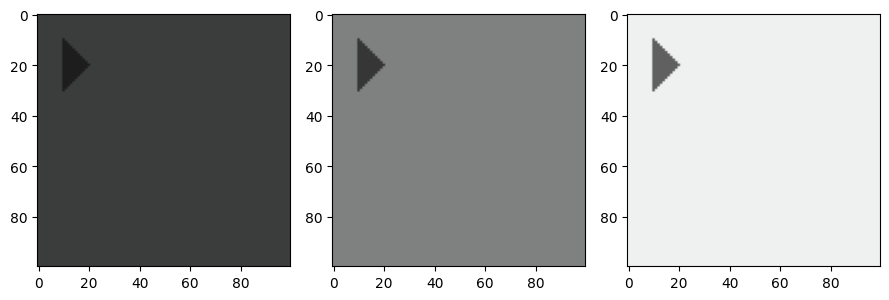

In [9]:
import torch
import matplotlib.pyplot as plt


def visualize_binary_masks(mask):
    plt.imshow(mask.cpu().numpy(), cmap="gray")  # Display mask in grayscale
    plt.tight_layout()
    plt.show()


def visualize_perturbed_inputs(X):
    n, c, h, w = X.shape
    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    for i in range(n):
        ax = axes.flat[i]
        # Transpose from (c, h, w) to (h, w, c) for matplotlib. Removed depth channel
        image = torch.permute(X[i][0:3], (1, 2, 0))
        image = image.cpu().numpy().astype(np.uint8)
        print(image)
        ax.imshow(image, cmap="gray", vmin=0, vmax=255)  # Ensure the values are in uint8 format for display
    plt.tight_layout()
    plt.show()


# Random input
n, c, h, w = 3, 4, 100, 100
X = torch.ones((n, c, h, w), dtype=torch.float16) * 128
X[0] = 60
X[2] = 240

vertices = torch.tensor([[10, 10], [20, 20], [30, 10]], dtype=torch.float)
attacker = ShadowAttack(None, None, None)
mask = attacker.get_shadow_mask(vertices, h, w)
visualize_binary_masks(mask)

X_p = attacker.apply_shadow_mask(mask, X)

visualize_perturbed_inputs(X_p)

In [10]:
def check_points_inside_triangle(vertices, points):
    # Add the third dimension
    n = len(points)
    vertices_3d = torch.cat([vertices, torch.zeros(len(vertices), 1)], dim=1)
    points_3d = torch.cat([points, torch.zeros(n, 1)], dim=1)
    # Check by cross products
    a, b, c = vertices_3d
    cross1 = torch.cross(torch.broadcast_to(b - a, (n, 3)), points_3d - a, dim=1)[:, 2] <= 0
    cross2 = torch.cross(torch.broadcast_to(c - b, (n, 3)), points_3d - b, dim=1)[:, 2] <= 0
    cross3 = torch.cross(torch.broadcast_to(a - c, (n, 3)), points_3d - c, dim=1)[:, 2] <= 0
    return ~(cross1 ^ cross2) & ~(cross2 ^ cross3)

In [11]:
check_points_inside_triangle(
    vertices=torch.tensor([[1, 1], [2, 2], [3, 1]], dtype=torch.float),
    points=torch.tensor([[1.5, 1.5], [1, 1], [2, 0.9]], dtype=torch.float),
)

tensor([ True,  True, False])

Testing PSO


In [19]:
%load_ext autoreload
%autoreload 2

import PSO
import numpy as np
import torch
from torch import nn

# Params
n_particles = 20
dim = 6
c1 = 1.5
c2 = 1.5
w = 0.5
num_iters = 100

pos_lb = torch.zeros(dim)
pos_ub = torch.ones(dim) * 255.0
pos_constraint = torch.stack((pos_lb, pos_ub), dim=0)
speed_lim = 30.0
vel_lb = -torch.ones(dim) * speed_lim
vel_ub = torch.ones(dim) * speed_lim
vel_constraint = torch.stack((vel_lb, vel_ub), dim=0)

# Arbitrary model
model = nn.Sequential(
    nn.Linear(in_features=dim, out_features=1),
    nn.ReLU(),
)


# Define particle's loss function
def cost_fn(particle: torch.Tensor):
    # I won't actually use this value, just for testing that my multiprocessing works with nn modules.
    with torch.no_grad():
        x = model(particle)
    # Returns negative sum of values, so optimal would be (255,255, ...)
    return -torch.sum(particle).item()


# Create PSO
optimizer = PSO.PSO(
    num_iters=num_iters,
    n_particles=n_particles,
    dim=dim,
    c1=c1,
    c2=c2,
    w=w,
    pos_constraint=pos_constraint,
    vel_constraint=vel_constraint,
)

best_cost, best_particle = optimizer.optimize(cost_fn=cost_fn)

print(best_cost, best_particle)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 100/100 [00:00<00:00, 2354.93it/s]

tensor(-1530.) tensor([252.8755, 255.0000, 255.0000, 255.0000, 255.0000, 255.0000])
